In [422]:
from os import listdir

import pandas as pd
import numpy as np
import scipy.stats as stats

import math

from sklearn import preprocessing

import statsmodels.formula.api as sm
import statsmodels.api as smstats
from statsmodels.tools.tools import add_constant

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks", color_codes=True)
sns.set_context('notebook')
sns.set_style('darkgrid')

In [423]:
xl = pd.ExcelFile('Multivariate_Data_Analysis_6e_Datasets_EXCEL.xls')

In [424]:
xl.sheet_names

['HBAT',
 'HBAT_200',
 'HBAT_MISSING',
 'HBAT_SPLITS',
 'HBAT_CPLAN',
 'HBAT_CONJOINT',
 'HBAT_MDS',
 'HBAT_CORRESP',
 'HBAT_SEM',
 'HBAT_SEM_NOMISSING',
 'HATCO',
 'SALES']

In [425]:
df = xl.parse('HBAT')

![title](data_dictionary.png)

In [426]:
def heatmap_correlation(df, title = ''):
    ## heatmeap to see the correlation between features. 
    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(df.corr())
    #mask[np.triu_indices_from(mask)] = True

    plt.subplots(figsize = (24,16))
    plt.subplots_adjust(top=0.90)
    sns.heatmap(df.corr(), 
                annot=True,
                #mask = mask,
                cmap = 'RdBu_r',
                linewidths=0.1, 
                linecolor='white',
                vmax = 1,
                square=True,
               fmt='.3f')
    plt.title(title, y = 1.03,fontsize = 20);

In [427]:
dependent_var = 'X19'

# Independent variables:
cols = ['X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18']
col_names = {
    'X6': 'Product Quality X6',
    'X7': 'E-Commerce X7',
    'X8': 'Technical Support X8',
    'X9': 'Complaint Resolution X9',
    'X10': 'Advertising X10',
    'X11': 'Product Line X11',
    'X12': 'Salesforce Image X12',
    'X13': 'Competitive Pricing X13',
    'X14': 'Warranty & Claims X14',
    'X15': 'New Products X15',
    'X16': 'Order & Billing X16',
    'X17': 'Price Flexibility X17',
    'X18': 'Delivery Speed X18',
    'X19': 'Customer Satisfaction X19'
}

corr_cols = cols.copy()
corr_cols.insert(0, dependent_var)
corr_df = df[corr_cols].copy()

summary_columns = pd.MultiIndex.from_tuples([
        ('', 'Step'),
        ('', 'Var.'),
        ('Overall Model Fit', 'R'),
        ('Overall Model Fit', 'Rˆ2'),
        ('Overall Model Fit', 'Adjusted Rˆ2'),
        ('Overall Model Fit', 'Std. Error of the Estimate'),
        ('Rˆ2 Change Statistics','Rˆ2 Change'),
        ('Rˆ2 Change Statistics','F Value of Rˆ2 Change'),
        ('Rˆ2 Change Statistics','df1'),
        ('Rˆ2 Change Statistics','df2'),
        ('Rˆ2 Change Statistics','Significance of Rˆ2 Change'),
    ])

model_summary = pd.DataFrame(columns=summary_columns)

model_summary

Empty DataFrame
Columns: [(, Step), (, Var.), (Overall Model Fit, R), (Overall Model Fit, Rˆ2), (Overall Model Fit, Adjusted Rˆ2), (Overall Model Fit, Std. Error of the Estimate), (Rˆ2 Change Statistics, Rˆ2 Change), (Rˆ2 Change Statistics, F Value of Rˆ2 Change), (Rˆ2 Change Statistics, df1), (Rˆ2 Change Statistics, df2), (Rˆ2 Change Statistics, Significance of Rˆ2 Change)]
Index: []

### Model Summary of Stepwise Multiple Regression Model

In [428]:
#FIXME - "stde_est" It should be passed as argument
#FIXME - "model_summary" should not be global
#TODO FIXME - F Value of Rˆ2 Change

def update_model_summary(OLSResults, vars_entered_into_rm, ve):
    
    #Overall Model Fit
    r = round(math.sqrt(OLSResults.rsquared),3)
    rsquared = round(OLSResults.rsquared,3)
    rsquared_adj = round(OLSResults.rsquared_adj,3)

    #Rˆ2 Change Statistics
    step = model_summary.shape[0]+1
    if step > 1:
        previous_rsquared = model_summary.loc[step-1]['Overall Model Fit']['Rˆ2']
        r2_change = round((rsquared - previous_rsquared),3)
    else:
        r2_change = round(rsquared,3)
        
    f_value_r2_change = round(OLSResults.fvalue,3) #FIXME
    df1 = OLSResults.df_model
    df2 = OLSResults.df_resid
    sign_of_r2_change = vars_entered_into_rm.loc[ve]['P>|t|']

    model_summary.loc[step] = (step,ve,r,rsquared,rsquared_adj, round(stde_est, 3), r2_change, f_value_r2_change, df1, df2, sign_of_r2_change)
    
model_summary    

Empty DataFrame
Columns: [(, Step), (, Var.), (Overall Model Fit, R), (Overall Model Fit, Rˆ2), (Overall Model Fit, Adjusted Rˆ2), (Overall Model Fit, Std. Error of the Estimate), (Rˆ2 Change Statistics, Rˆ2 Change), (Rˆ2 Change Statistics, F Value of Rˆ2 Change), (Rˆ2 Change Statistics, df1), (Rˆ2 Change Statistics, df2), (Rˆ2 Change Statistics, Significance of Rˆ2 Change)]
Index: []

### Colinearity diagnosis (Tolerance and VIF)

In [429]:
def vif_calc(x_vars):
    vif_tol = pd.DataFrame(columns=['Tolerance', 'VIF'])

    xvar_names = x_vars.columns
    for col in xvar_names:
        y = x_vars[col] 
        x = x_vars[xvar_names.drop(col)]
        x = add_constant(x)

        rsq = sm.OLS(y,x).fit().rsquared  
        
        vif = round(1/(1-rsq),3)
        tolerancy = round(1-rsq, 3)

        vif_tol.loc[col] = (tolerancy, vif)
        
    return vif_tol

### OLS (Ordinary Least Squares Model)

In [430]:
def OLS(y,x):
    df = corr_df.copy()
    X = df[x]; 
    y = df[y]
    
    X = add_constant(X)
    model = sm.OLS(y, X).fit()
    
    return model

### Variables Entered the into Regression Model

In [431]:
def variables_entered(dependent_var, varse):
    df = corr_df.copy()
    
    results = OLS(dependent_var, varse)
    vif_tol = vif_calc(df[varse])

    rs = results.summary()

    '''Note that tables is a list. The table at index 1 is the "core" table. 
       Additionally, read_html puts dfs in a list, so we want index 0
    '''
    results_as_html = rs.tables[1].as_html()
    table1 = pd.read_html(results_as_html, header=0, index_col=0)[0]
    table1 = round(table1,3)

    return pd.concat([table1,vif_tol], axis=1, join='inner')

### ANOVA

In [432]:
def anova(y, varse):
    df = corr_df.copy()
    X = add_constant(df)
    formula = y + '~' + '+'.join(varse)
    mod = sm.ols(formula, data=X).fit()
    
    aov_table = smstats.stats.anova_lm(mod, typ=2)
    aov_table = round(aov_table,3)
    
    return aov_table

In [433]:
# infl = results.get_influence()
# df_infl = infl.summary_frame()
# round(df_infl[:5],3)

### Partial correlation
- First order
![title](first_order.png)
- High order
![title](high_order.png)

In [434]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

columns = pd.MultiIndex.from_tuples([
        ('', 'Beta In'),
        ('Statistical Significance', 't-value'), ('Statistical Significance', 'Significance'),
        ('', 'Partial Correlation'),
        ('Collinearity Statistics', 'Tolerance'),('Collinearity Statistics', 'VIF')
    ])

zero_order_corr = corr_df.corr()

def calc_abc(ab,ac,bc):
    return (ab-ac*bc) / (np.sqrt(1-pow(ac, 2)) * np.sqrt(1-pow(bc, 2)))

def first_order(a, b, c):
    ra = zero_order_corr.loc[a,b] 
    rb = zero_order_corr.loc[a,c] 
    rc = zero_order_corr.loc[b,c]

    return calc_abc(ra,rb,rc)

def partial_correlation(j,k,p,varse):
    if(len(varse)==1):
        return first_order(j,k,p)
    
    return calc_abc(
        partial_correlation(j, k, varse[-2], varse[:-1]),
        partial_correlation(j, varse[-1], varse[-2], varse[:-1]),
        partial_correlation(k, varse[-1], varse[-2], varse[:-1])
    )

def partial_correlations(j, k, varse):
    rjkp = partial_correlation(j, k, varse[0], varse.copy())

    return round(rjkp,3)

def vif_in(X, v):  
    p = pd.Series(variance_inflation_factor(X.values, 1), index=X.columns)

    vif = p[v]
    tolerance = 1/vif
    
    return (round(tolerance,3), round(vif,3))

def beta_stats_sign(Y, X, k):
    df = corr_df.copy()
    
    model = sm.OLS(Y, X)
    result = model.fit()

    #beta
    beta_in = result.params[k]

    #t, p-value, dof
    t = result.tvalues[k]
    p = result.pvalues[k]
    dof = df.shape[0]-2
    significance = stats.t.sf(abs(t), dof)*2

    return (round(beta_in,3), round(t,3), round(significance,3))

def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    if(s.name[1] in ['Significance', 'VIF']):
        is_min = s == s.min() 

        return ['background-color: yellow' if v else '' for v in is_min]
    else:
        is_max = s == s.max()
        
        return ['background-color: yellow' if v else '' for v in is_max]

def variables_not_entered_int_rm(y, varse):
    df = corr_df.copy()
    
    stats_sign = pd.DataFrame(columns=columns)
    
    # standardizing dataframe
    df_z = df.select_dtypes(include=[np.number]).dropna().apply(stats.zscore)
    
    for k in df_z.columns:
        if(k == y or k in varse):
            continue   
            
        Y = df_z[y]
        X = add_constant(df_z[[k]+varse])
        
        #Beta and Statistical significance
        beta_in, t, sig = beta_stats_sign(Y,X,k)
        
        #Tolerance, Vif
        tolerance,vif = vif_in(X, k)
        
        #Partial correlation
        partial_correlation = partial_correlations(y, k, varse)

        stats_sign.loc[col_names[k]] = (beta_in,t,sig, partial_correlation, tolerance, vif)
        
    return stats_sign.style.apply(highlight_max)

In [435]:
# r12 = .603 #X19 and X9
# r13 = .486 #X19 and X6
# r23 = .106 #X9 and X6

# partial = (r12-r13*r23) / (np.sqrt(1-pow(r13, 2)) * np.sqrt(1-pow(r23, 2)))
# print("X9 partial: ", round(partial, 3))

In [436]:
# x9_semipartial_corr = (r12-r13*r23) / np.sqrt(1-pow(r23, 2))
# x9_semipartial_corr = round(x9_semipartial_corr, 3)
# print("Semipartial of X9 and X19 with X6 controlled: ", x9_semipartial_corr)
# print("Unique variance previewd X9: ", round(pow(x9_semipartial_corr, 2),3) )

In [437]:
# x6_semipartial_corr = (r12-r13*r23) / np.sqrt(1-pow(r13, 2))

# x6_semipartial_corr = round(x6_semipartial_corr, 3)
# print("Semipartial of X6 and X19 with X9 controlled: ", x6_semipartial_corr)
# print("Unique variance previewd X6: ", round(pow(x6_semipartial_corr, 2),3) )


In [438]:
# listdir()

### Analysis of Standardized Residuals

In [439]:
def plot_standardized_residuals(Y,X):
    model = OLS(Y,X)

    infl = model.get_influence()

    x = preprocessing.scale(model.fittedvalues)
    y = infl.resid_studentized_external

    plt.figure(figsize=(8,6))
    ax = sns.residplot(x, y)
    ax.set_ylim(-3,3)
    ax.set_xlim(-3,3)
    ax.set(xlabel='Standardized Predicted Value', ylabel='Studentized Residual')
    plt.show()

In [440]:
def partial_regression_plots(Y,X):
    model = OLS(Y,X)
    
    fig = plt.figure(figsize=(14,14))
    fig.subplots_adjust(hspace=0.8, wspace=0.8)

    fig = smstats.graphics.plot_partregress_grid(model, fig=fig)

In [441]:
def norm_prob_residuals_plot(Y, X):
    model = OLS(Y, X)

    res = model.resid

    fig = plt.figure()
    pp_x = smstats.ProbPlot(res, fit=True)
    fig = pp_x.ppplot(line='45')

![title](stage1_3.png)

# Stage 1: Objectives of Multiple Regression 

The following 13 variables were included as independent variables:

We selecte **Customer Satisfaction (X19)** as the dependent variable (**Y**) to predicted by independent variables. 

The relationship among the 13 independent variables and customer satisfaction was assumed to be statistical, not functional, because it involved perceptions of performance and may include levels of measurement error.

![title](variables.png)

In [442]:
df[cols].head(5)

,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
0,8.5,3.9,2.5,5.9,4.8,4.9,6.0,6.8,4.7,4.3,5.0,5.1,3.7
1,8.2,2.7,5.1,7.2,3.4,7.9,3.1,5.3,5.5,4.0,3.9,4.3,4.9
2,9.2,3.4,5.6,5.6,5.4,7.4,5.8,4.5,6.2,4.6,5.4,4.0,4.5
3,6.4,3.3,7.0,3.7,4.7,4.7,4.5,8.8,7.0,3.6,4.3,4.1,3.0
4,9.0,3.4,5.2,4.6,2.2,6.0,4.5,6.8,6.1,4.5,4.5,3.5,3.5


In [499]:
df[cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
X6     100 non-null float64
X7     100 non-null float64
X8     100 non-null float64
X9     100 non-null float64
X10    100 non-null float64
X11    100 non-null float64
X12    100 non-null float64
X13    100 non-null float64
X14    100 non-null float64
X15    100 non-null float64
X16    100 non-null float64
X17    100 non-null float64
X18    100 non-null float64
X3     100 non-null int64
dtypes: float64(13), int64(1)
memory usage: 11.0 KB


# Stage 2: Research Design of a Multiple Regression Analysis

- The first question to be answered concerning sample size is the level of relationship **(Rˆ2)** that can be detected reliably with the proposed regression analysis. 

- **Table 5** indicates that the sample of 100, with 13 potential independent variables, is able to detect relationships with Rˆ2 values of approximately **23%** at power of **.80** with the significance level set at **.01**. If the significance level is relaxed to **.05**, then the analysis will identify relationships explaining about **18%** of the variance. 

- The sample of 100 observartions also meets the guideline for the minimum ratio of observations to indepent variables (**5:1**) with an actual ratio of **7:1** (100 observations with 13 variables)

    The proposed regression analysis was deemed sufficient to identify not only statistically significant relationships but also relationships that had managerial significance

- ####  Table 5 - Minimum Rˆ2 That Can Be Found Statistically Significant with a Power of .80 for Varying Numbers of Independent Variables and Sample Sizes

![title](minimum_r2.png)

# Stage 3: Assumptions in Multiple Regression Analysis

Analysis to ensure the research is meeting the basic assumptions of regression analysis involves two steps:

    1 - Testing the individual dependent and independent variables
    2 - Testing the overall relationship after model estimation.

# Stage 3.1.1 - Scatterplots to verify non-linear relationships

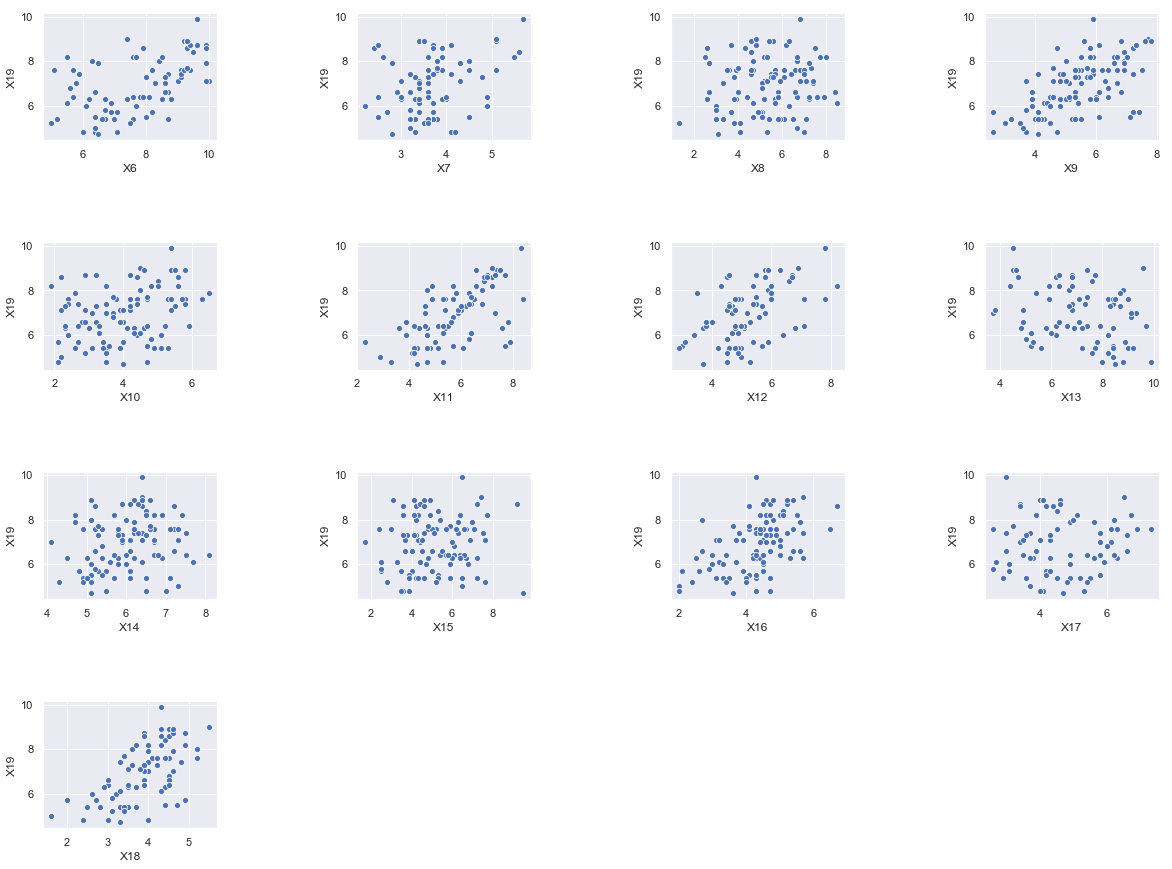

In [443]:
fig = plt.figure(figsize=(20,15))
fig.subplots_adjust(hspace=0.8, wspace=0.8)

for idx, col in enumerate(cols):
    ax = fig.add_subplot(4, 4, idx+1)
    sns.scatterplot(x = corr_df[col], y=corr_df[dependent_var], ax=ax)

- Scatterplots of the individual variables did not indicate any nonlinear relationships between the dependent **(X19)** and the independent variables

# Stage 3.1.1 -  Checking normality

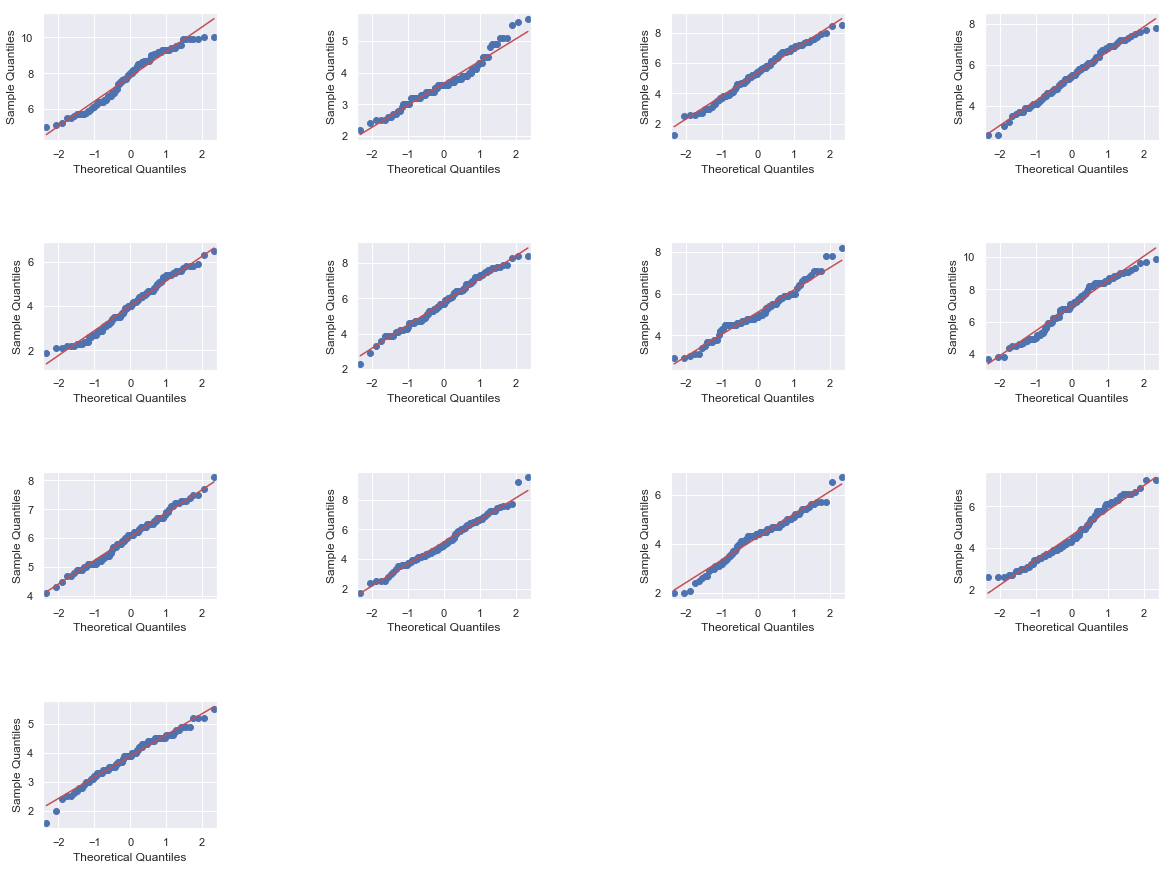

In [444]:
fig = plt.figure(figsize=(20,15))
fig.subplots_adjust(hspace=0.8, wspace=0.8)

#TODO var name for each plot
for idx, col in enumerate(cols):
    ax = fig.add_subplot(4, 4, idx+1)
    smstats.qqplot(df[col], line='s', ax=ax)

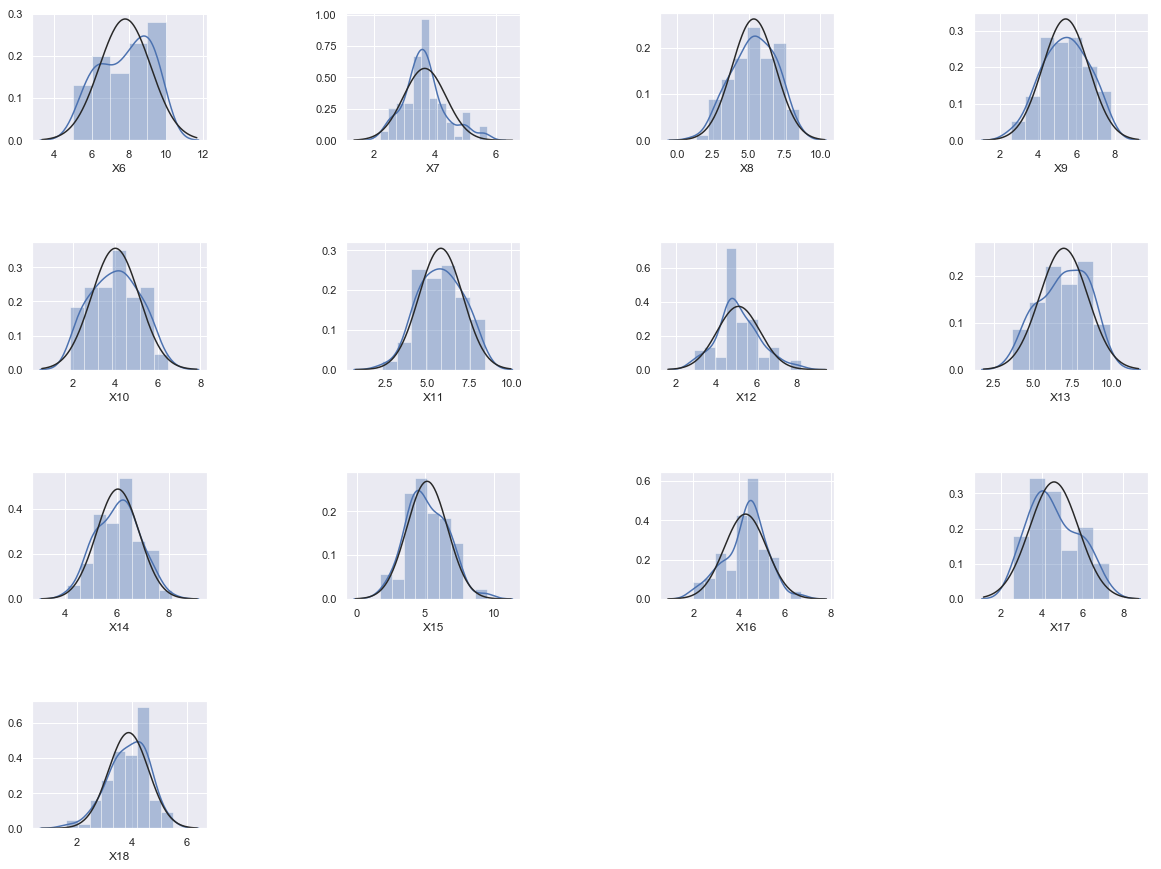

In [445]:
fig = plt.figure(figsize=(20,15))
fig.subplots_adjust(hspace=0.8, wspace=0.8)

for idx, col in enumerate(cols):
    ax = fig.add_subplot(4, 4, idx+1)
    sns.distplot(df[col], fit=stats.norm, ax=ax);
    stats.probplot(df[col])    

- ### skewness and kurtosis

In [446]:
sk = pd.DataFrame(columns=['Skewness', 'Kurtosis'], index=cols)
for col in cols:
    skewness = corr_df[col].skew()
    kurtosis = corr_df[col].kurt()
    sk.loc[col] = (round(skewness,3),round(kurtosis,3))
sk

,Skewness,Kurtosis
X6,-0.245,-1.132
X7,0.66,0.735
X8,-0.203,-0.548
X9,-0.136,-0.586
X10,0.044,-0.888
X11,-0.092,-0.522
X12,0.377,0.41
X13,-0.24,-0.903
X14,0.008,-0.445
X15,0.299,0.016


- Six variables were found to violate the statistical tests
    * **X6** 
    * **X7**
    * **X12**
    * **X13**
    * **X16**
    * **X17**
    
- For all, except one **(X12)**, transformations were sufficient remedies.

# Stage 3.1.2 - Checking heteroscedasticity

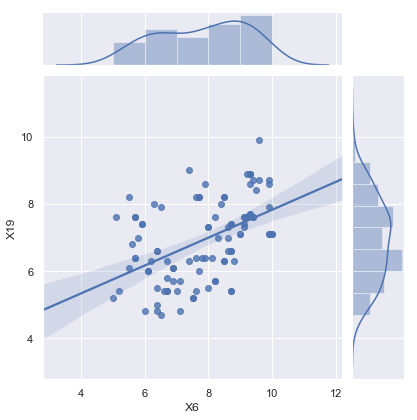

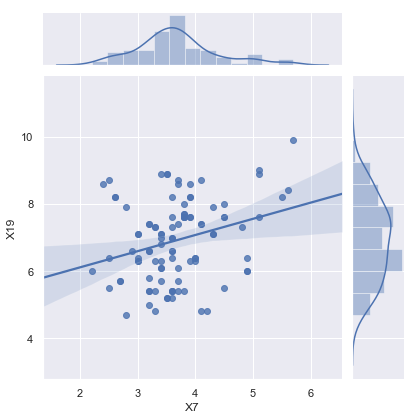

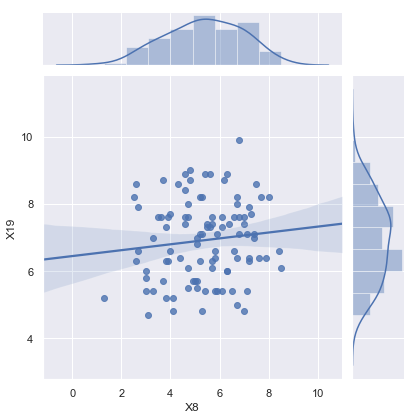

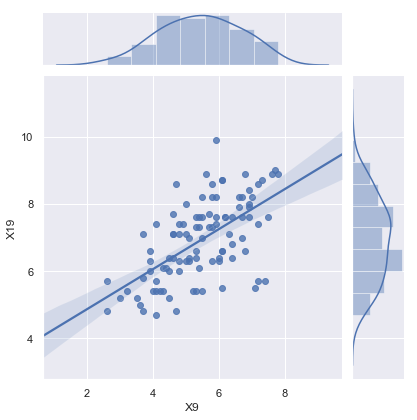

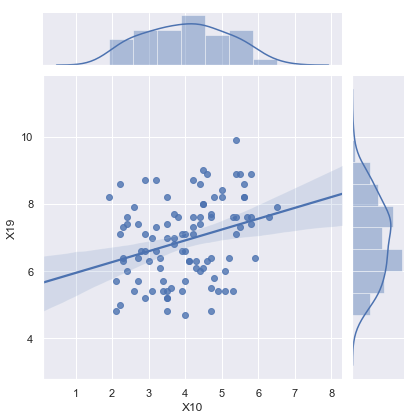

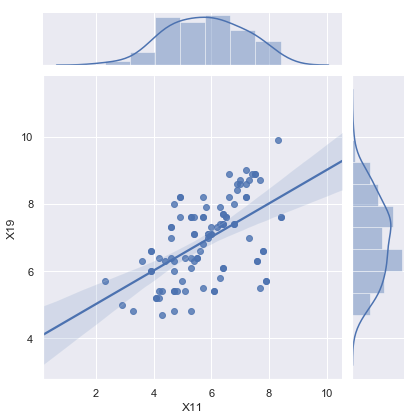

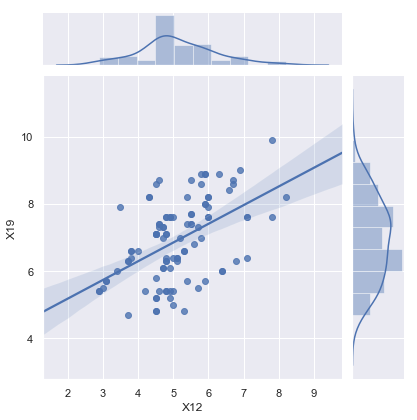

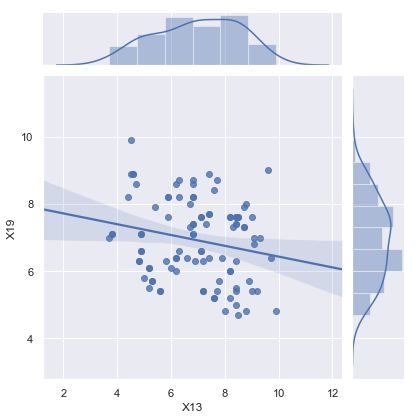

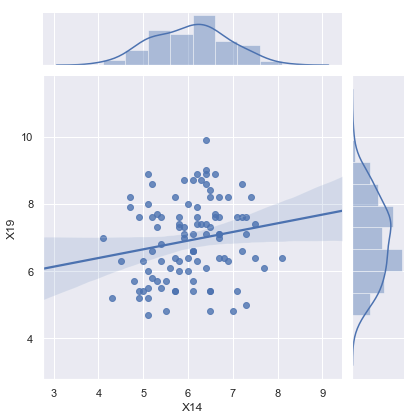

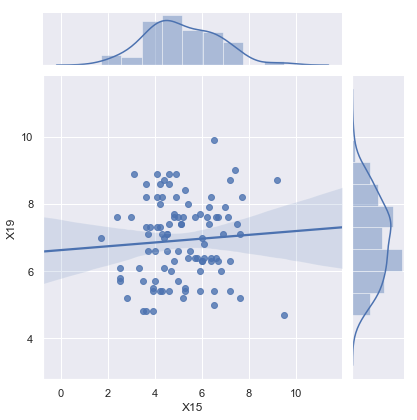

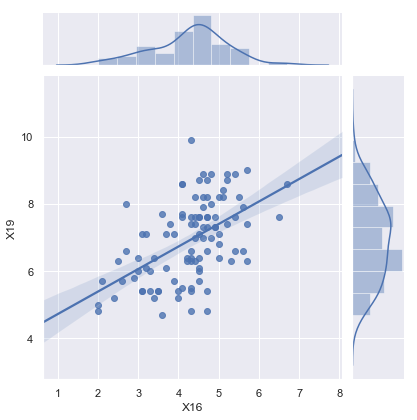

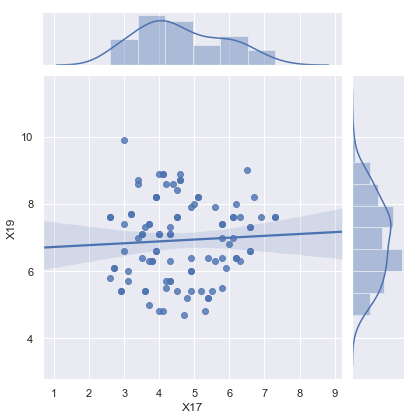

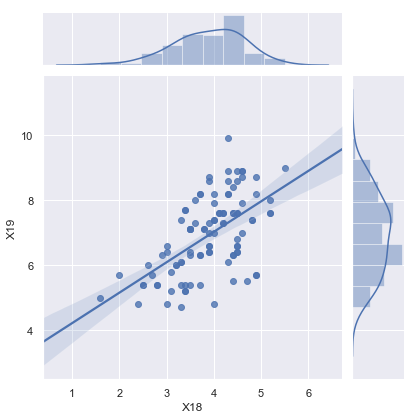

In [447]:
for idx, col in enumerate(cols):
    sns.jointplot(x=corr_df[col], y=corr_df[dependent_var], kind='reg')

* Only two variables **(X6 and X17)** had minimal violations of this assumption, with no corrective action needed

* Although regression analysis has been shown to be quite robust even when the normality assumption is violated, researches should estimate the regression analysis with both the original and transformed variables to assess the consequences of nonnormality of the independent variables on the interpretation of the results. 

* Here we use the original variables and later results for the transformed variables are shown for comparison

![title](stage4_6.png)

# Stage 4: Estimating the Regression Model and Assessing Overall Model Fit

- With the regression analysis specified in terms of dependent and independent variables, the sample deemeded adequate for the objectives of the study, and the assumptions assessed for the individual variables, the model-building process now proceeds to estimation of the regression model and assessing the overall model fit.

- For purposes of illustration, the stepwise procedure is employed to select variables for inclusion in the regression variable

### Stepwise estimation: Selecting the first variable

- The stepwise estimation procedure maximizes the incremental **explained variance** at each step of model building.
- In the first step, the **highest bivariate correlation** will be selected

![title](stepwise_estimation.png)

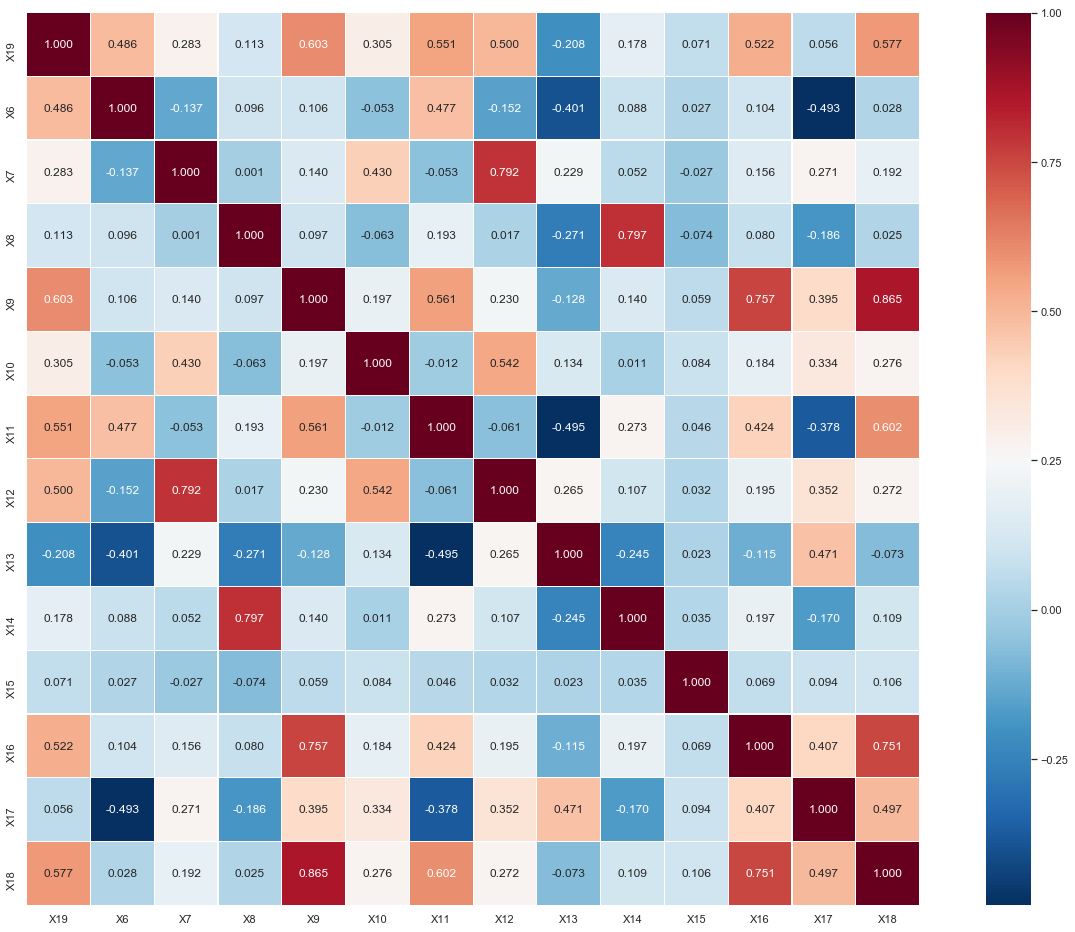

In [448]:
heatmap_correlation(corr_df)

- Examination of the correlation matrix reveals that **compaint resolution (X9)** has the highest bivariate correlation with the dependent variable **X19** (**0,603**). 
- The first step is to build a regression equation using just this single independent variable

In [449]:
varse = ['X9']

In [501]:
results = OLS(dependent_var, varse)
results.summary().tables[0]

Dep. Variable:,X19,R-squared:,0.801
Model:,OLS,Adj. R-squared:,0.788
Method:,Least Squares,F-statistic:,62.46
Date:,"Mon, 25 Mar 2019",Prob (F-statistic):,1.78e-30
Time:,16:25:54,Log-Likelihood:,-78.171
No. Observations:,100,AIC:,170.3
Df Residuals:,93,BIC:,188.6
Df Model:,6,,
Covariance Type:,nonrobust,,


In [451]:
stde_est = np.sqrt(results.ssr / results.df_resid)

In [452]:
anova(dependent_var, varse)

,sum_sq,df,F,PR(>F)
X9,51.178,1.0,56.07,0.0
Residual,89.450,98.0,NaN,NaN


In [453]:
vars_entered_into_rm = variables_entered(dependent_var, varse)    
vars_entered_into_rm

,coef,std err,t,P>|t|,[0.025,0.975],Tolerance,VIF
X9,0.595,0.079,7.488,0.0,0.437,0.753,1.0,1.0


In [454]:
update_model_summary(results, vars_entered_into_rm, 'X9')
model_summary

Overall Model Fit                                                 \
  Step Var.                 R    Rˆ2 Adjusted Rˆ2 Std. Error of the Estimate   
1    1   X9             0.603  0.364        0.357                      0.955   

  Rˆ2 Change Statistics                                   \
             Rˆ2 Change F Value of Rˆ2 Change  df1   df2   
1                 0.364                 56.07  1.0  98.0   

                              
  Significance of Rˆ2 Change  
1                        0.0

##  Variables Entered into the Regression Model

- **Multiple R** is the correlation  coefficient (at this step) for the simple regression of **X9 and X19**. It has no plus or minus sign because in multiple regression the signs of the individual variables may vary, so this coefficient reflects only the degree of association. In the first step of the stepwise estimation, the Multiple R is the same as the bivariate correlation (**.603**) because the equation contains only one variable
- **R-squared** is the correlation coefficient squared (**.603ˆ2 = .364**), also referred to as the *coefficient of determination*. This value indicates the percentage of total variation of Y (*X19, Customer Satisfaction*) explained by the regression model consisting of **X9**
- **Standard Error of the Estimate** is another measure of the accuracy of our predictions. It is the **sqrt(sum_sq)/df**, also represented by the sqrt of the ***MSresidual***. 
    - It represents an estimate of the standard deviation of the actual dependent values around the regression line; that is, it is a measure of variation around the regression line. Also can be viewed as the standard deviation of the prediction errors; thus it becomes a measure to assess the absolute size of the prediction error. It is used also in estimating the size of the confidence interval for the predictions
- ***ANOVA and F Ratio***  The *ANOVA* analysis provides the statistical test for the overall model fit in terms of the *F ratio*. 
    - The total sum of squares is the squared error that would ocurr if we used only the mean of Y to predict the dependent variable. Using the values of *X9* reduces this error by **36.4 percent** (51.178/140.628). This reduction is deemed statistically significant with an ***F ratio*** of **56.070** and a **significance level of .000**    

- **Variables in the Equation (Step 1)** In step 1, a single independent variable **(X9)** is used to calculate the regression equation for prediction the dependent variable. For each variable in the equation, several measures need to be defined: 
    - **The regression coefficient (b)**: Reflect the change in the dependent measure for each unit change in the Y. Comparison between regression coefficients allows for a relative assessment of each variable's importance in the regression model. The value **.595** is the regression coefficient *(**b9**)* for the **Y (X9)**. The predicted value for each observation in the intercept **(*Y* = 3.680 + .595X9)**.
    
    - **The standard error of the coefficient**: In a simple sense, it is the standard deviation of the estimates of ***b9*** across multiple samples. A smaller standard error implies more reliable prediction and therefore smaller confidence intervals. 
        - The standard error of ***b9*** is **.079**, denoting that the **95%** confidence interval for ***b9*** would be **.595 ± (1.96 x .079)**, or ranging from a low of **.44** to a high of **.75**. 
        - The value of ***b9*** divided by the standard error **(.595/.079 = 7.488)** is the calculated ***t*** value for a ***t-test*** of the hypothesis ***b9* = 0**
    - **The *t* value of variables in the Equation**: as just calculated, measures the significance of the partial correlation of the variable reflected in the regression coefficient. As such, it indicates whether the researcher can confidently say, with a stated level of error, that the coefficient is not equal to zero. ***F*** values may be given at this stage rather than ***t*** values.
        - They are directly comparable beacause the ***t*** value is approximately the square root of the ***F value***.
        - Is also particularly useful in the stepwise procedure in helping to determine whether any variable should be dropped from the equation once another independent variable has been added. The calculated level of significance is compared to the threshold level set by the researcher for dropping the variable. In our example, we set a **.10** level for dropping variables from the equation. 
        - The critical value for a significance level of **.10** with **98 df** is **1.658**. As more variables are added to the regression equation, each variable is checked to see whether it still falls within this threshold. If it falls outside the threshold (**significance > .10**), it is eliminanted from the regression equation, and the model is estimated again
        - In our example, the ***t*** value (as derived by dividing the regression coefficient by the standard error) is **7.488**, which is statistically significant at the **.000** level. It gives the researcher a high level of assurance that the coefficient is not equal to zero and can be assessed as a predictor of customer satisfaction.
        
    - ***Correlations*** Three different correlations are given as an aid in evaluating the estimation process. 
        - The ***zero-order*** correlation is the simple bivariate correlation between the independent and dependent variable. 
        - The ***partial correlation*** denotes the incremental predictive effect, controlling for other variables in the regression model on both dependent and independent variables. This measure is used for judging which variable is next added in sequential search methods. 
        - Finally, the ***part correlation*** denotes the unique effect attributable to each independent variable.
        - For the first step in a stepwise solution, all three correlations are identical (**.603**) because no other variables are in the equation. As variables are added, these values will differ, each reflecting their perspective on each independent variable’s contribution to the regression model.    
    - **The collinearity diagnosis (tolerance and VIF):** provide a perspective on the impact of collinearity on the independent variables in the regression equation. In the case of a single variable in the regression model, the tolerance is **1.00**, indicating that it is totally unaffected by other independent variables (as it should be since it is the only variable in the model). Also, the VIF is **1.00**. Both values indicate a complete lack of multicollinearity.

###  Variables Not Entered into the Regression Model

In [455]:
vars_notent_into_rm = variables_not_entered_int_rm(dependent_var, varse)
vars_notent_into_rm

###  Variables Not Entered into the Regression Model

- With *X9* included in the regression equation, 12 other potential independent variables remain for inclusion to improve the prediction of the dependent variable. For each of these variables, four types of measures are available to assess their potential contribution to the regression model:
    
    - **Partial correlations and Collinearity Measures**: is a measure of the variation in Y that can be accounted for by each of these additional variables, controlloing for the variables already in the equation (only *X9* in step 1). If the variable with the highest partial correlation exceeds the threshold of statistical significance required for inclusion, it will be added to the regression model at the next step. The partial correlation represents the correlation of each variable in the model with the unexplained portion of dependent variable. As such, the contribution of the partial correlation (the squared partial correlation) is that percentage of the unexplained variance that is explained by the addicion of this independent variable. 
    
    It is interesting to note, however, that
        - ***X6*** had only the **sixth highest bivariate** correlation with *X19*. Why was it the second variable to enter the stepwise equation, ahead of the variables with higher correlations? 
        - The variables with the **second highest correlations with X19** were ***X18*** (**.577**), 
        - **Third**, ***X11*** (**.551**) 
        - **Fourth**, ***X16*** (**.522**) 
        - Both *X18* and *X16* had high correlations with X9, reflected in their rather low tolerance values of .252 and .427, respectively. It should be noted that this fairly high level of multicollinearity is not unexpected, because these three variables (X9, X16, and X18) constituted the first factor that would be derived in a first factor analysis (not performed here). X11, even though it does not join this factor, is highly correlated with X9 (.561) to the extent that the tolerance is only .685. 
        - Finally, ***X12***, the **fifth highest bivariate** correlation with X19, only has a correlation with X9 of **.230**, but it was just enough to make the partial correlation slightly lower than that of X6. The correlation of X9 and X6 of only **.106** resulted in a tolerance of **.989** and transformed the bivariate correlation of **.486** into a partial correlation of **.532**, which was highest among all the remaining 12 variables.
        
        If *X6* is added, then the R2 value should increase by the partial correlation squared times the amount of unexplained variance **(change in R2 = .532ˆ2 * .636 = .180)**. Because **36.4** percent was already explained by *X9*, *X6* can explain only **18.0** percent of the remaining variance. 
    
    - **Standardized coefficients (Beta)** 
        - We see that ***X6***, the variable with the highest partial correlation, also has the highest Beta coefficient if entered. Even though the magnitude of **.427** is substantial, it can also be compared with the beta for the variable now in the model (***X9*** with a **beta** of **.603**), indicating that *X6* will make a substantive contribution to the explanation of the regression model, as well as to its predictive capability.
    
    - ***t* values** The *t* value measures the significance of the partial correlations for variables not in the equation. They are calculated as a ratio of the additional sum of squares explained by including a particular variable and the sum of squares left after adding that same variable. If this t value does not exceed a specified significance level (e.g., .05), the variable will not be allowed to enter the equation.
        
        - We note that six variables *(X6, X7, X10, X11, X12, and X17)* exceed this value and are candidates for inclusion. Although all are significant, the variable added will be that variable with the highest partial correlation. We should note that establishing the threshold of statistical significance before a variable is added precludes adding variables with no significance even though they increase the overall R2.


**Looking Ahead** With the first step of the stepwise procedure completed, the final task is to evaluate the variables not in the equation and determine whether another variable meets the criteria and can be added to the regression model. As noted earlier, the partial correlation must be great enough to be statistically significant at the specified level (generally .05). If two or more variables meet this criterion, then the variable with the highest partial correlation is selected.

As described earlier, **X6 (Product Quality**) has the highest partial correlation at this stage, even though four other variables had higher bivariate correlations with the dependent variable. In each instance, multicollinearity with X9, entered in the first step, caused the partial correlations to decrease below that of X6.

We know that a significant portion of the variance in the dependent variable is explained by X9, but the stepwise procedure indicates that if we add X6 with the highest partial correlation coeffi- cient with the dependent variable and a ***t value*** is **significant at the .05 level**, we will make a significant increase in the predictive power of the overall regression model. Thus, we can now look at the new model using both X9 and X6.

### Stepwise estimation: Selecting the second variable (X6)

The next step in a stepwise estimation is to check and delete any of the variables in the equation that now fall below the significance threshold, and once done, add the variable with the **highest statistically significant partial correlation**.

In [456]:
varse.append('X6')

In [457]:
results = OLS(dependent_var, varse)
results.summary().tables[0]

Dep. Variable:,X19,R-squared:,0.544
Model:,OLS,Adj. R-squared:,0.535
Method:,Least Squares,F-statistic:,57.90
Date:,"Mon, 25 Mar 2019",Prob (F-statistic):,2.83e-17
Time:,13:57:22,Log-Likelihood:,-119.66
No. Observations:,100,AIC:,245.3
Df Residuals:,97,BIC:,253.1
Df Model:,2,,
Covariance Type:,nonrobust,,


In [458]:
stde_est = np.sqrt(results.ssr / results.df_resid)

In [459]:
anova(dependent_var, varse)

,sum_sq,df,F,PR(>F)
X9,43.267,1.0,65.473,0.0
X6,25.349,1.0,38.359,0.0
Residual,64.101,97.0,NaN,NaN


In [460]:
vars_entered_into_rm = variables_entered(dependent_var, varse)    
vars_entered_into_rm

,coef,std err,t,P>|t|,[0.025,0.975],Tolerance,VIF
X9,0.550,0.068,8.092,0.0,0.415,0.685,0.989,1.011
X6,0.364,0.059,6.193,0.0,0.248,0.481,0.989,1.011


- **Estimated Coefficients** 
    - The beta weight is **.427**. 
    - Although not as large as the beta for X9 **(.558)**, X6 still has a substantial impact in the overall regression model. 
    - The coefficient is statistically significant and multicollinearity is minimal with X9 (as described in the earlier section). 
    - Thus, tolerance is quite acceptable with a value of **.989** indicating that only **1.1** percent of either variable is explained by the other.
    
    
- **Impact of Multicollinearity** The lack of multicollinearity results in little change for either the value of b9 **(.550)** or the beta of X9 **(.558)** in step 1. It further indicates that variables X9 and X6 are relatively independent (the simple correlation between the two variables is **.106**). If the effect of X6 on Y were totally independent of the effect of X9, the b9 coefficient would not change at all. 
    - The ***t values*** indicate that both X9 and X6 are statistically significant predictors of Y. 
    - The ***t value*** for X9 is now **8.092**, whereas it was **7.488** in step 1. 
    - The ***t value*** for X6 relates to the contribution of this variable given that X5 is already in the equation. Note that the t value for X6 (**6.193**) is the same value shown for X6 in step 1 under the heading “Variables Not Entered into the Regression Model”
    




In [461]:
update_model_summary(results, vars_entered_into_rm, 'X6')
model_summary

Overall Model Fit                                                 \
  Step Var.                 R    Rˆ2 Adjusted Rˆ2 Std. Error of the Estimate   
1    1   X9             0.603  0.364        0.357                      0.955   
2    2   X6             0.738  0.544        0.535                      0.813   

  Rˆ2 Change Statistics                                   \
             Rˆ2 Change F Value of Rˆ2 Change  df1   df2   
1                 0.364                56.070  1.0  98.0   
2                 0.180                57.902  2.0  97.0   

                              
  Significance of Rˆ2 Change  
1                        0.0  
2                        0.0

- **Overall Model Fit** The **multiple R** and **R2** values have both increased with the addition of **X6**. 
    - The **R2** increased by **18.0 percent**
    - Then, of the **63.3** percent unexplained with X9, **(.532)ˆ2** of this variance was explained by adding X6, yielding a **total variance explained (R2)** of **.544**. 
    - The **adjusted R2** increased to **.535** 
    - The standard error of the estimate decreased from **.955 to .813**. 
    
    Both of these measures also demonstrate the improvement in the overall model fit.

In [462]:
vars_notent_into_rm = variables_not_entered_int_rm(dependent_var, varse)
vars_notent_into_rm

- **Identifying Variables to Add** 
    - Looking at the partial correlations for the variables not in the equation, we see that: 
        - **X12** has the highest partial correlation (**.676**), which is also statistically significant at the **.000** level. 
        - Would explain **45.7** percent of the heretofore unexplained variance (**.676ˆ2 = .457**), or **20.9** percent of the total variance (**.676ˆ2 * .456**). 

This substantial contribution actually slightly surpasses the incremental contribution of X6, the second variable entered in the stepwise procedure.

### Stepwise estimation: A third variable (X12) is added


In [463]:
varse.append('X12')

In [464]:
results = OLS(dependent_var, varse)
results.summary().tables[0]

Dep. Variable:,X19,R-squared:,0.753
Model:,OLS,Adj. R-squared:,0.745
Method:,Least Squares,F-statistic:,97.33
Date:,"Mon, 25 Mar 2019",Prob (F-statistic):,5.26e-29
Time:,13:57:23,Log-Likelihood:,-89.108
No. Observations:,100,AIC:,186.2
Df Residuals:,96,BIC:,196.6
Df Model:,3,,
Covariance Type:,nonrobust,,


In [465]:
stde_est = np.sqrt(results.ssr / results.df_resid)

In [466]:
anova(dependent_var, varse)

,sum_sq,df,F,PR(>F)
X9,25.141,1.0,69.365,0.0
X6,35.242,1.0,97.236,0.0
X12,29.306,1.0,80.858,0.0
Residual,34.794,96.0,NaN,NaN


In [467]:
vars_entered_into_rm = variables_entered(dependent_var, varse)   
vars_entered_into_rm

,coef,std err,t,P>|t|,[0.025,0.975],Tolerance,VIF
X9,0.433,0.052,8.329,0.0,0.330,0.536,0.927,1.079
X6,0.437,0.044,9.861,0.0,0.349,0.525,0.956,1.046
X12,0.530,0.059,8.992,0.0,0.413,0.647,0.916,1.092


- **Estimated Coefficients** 
    The addition of X12 brought a third statistically significant predictor of customer satisfaction into the equation. 
    - is complemented by a **beta weight** of **.477**, second highest among the three variables in the model (behind the **.512** of X6).
    
- **Impact of Multicollinearity** It is noteworthy that even with the third variable in the regression equation, multicollinearity is held to a minimum. 
    - The lowest tolerance value is for **X12** (**.916**), indicating that only **8.4** percent of variance of **X12** is accounted for by the other two variables. This pattern of variables entering the stepwise procedure should be expected, however, when viewed in light of a preliminary factor analysis. 
    
    From those results, we would see that the three variables now in the equation (**X9**, **X6**, and **X12**) are each members of different factors in that analysis. Because variables within the same factor exhibit a high degree of multicollinearity, it would be expected that when one variable from a factor enters a regression equation, the odds of another variable from that same factor entering the equation are rather low (and if it does, the impact of both variables will be reduced due to multicollinearity).
    

In [468]:
update_model_summary(results, vars_entered_into_rm, 'X12')
model_summary

Overall Model Fit                                                 \
  Step Var.                 R    Rˆ2 Adjusted Rˆ2 Std. Error of the Estimate   
1    1   X9             0.603  0.364        0.357                      0.955   
2    2   X6             0.738  0.544        0.535                      0.813   
3    3  X12             0.868  0.753        0.745                      0.602   

  Rˆ2 Change Statistics                                   \
             Rˆ2 Change F Value of Rˆ2 Change  df1   df2   
1                 0.364                56.070  1.0  98.0   
2                 0.180                57.902  2.0  97.0   
3                 0.209                97.333  3.0  96.0   

                              
  Significance of Rˆ2 Change  
1                        0.0  
2                        0.0  
3                        0.0

- **Overall Model Fit** As predicted, the value of **R2** increases by **20.9** percent (.753 - .544 = .209). Moreover, the **adjusted R2** increases to **.745** and the **standard error of the estimate decreases to .602**. Again, as was the case with **X6** in the previous step, the new variable entered (**X12**) makes substantial contribution to overall model fit.    

In [469]:
vars_notent_into_rm = variables_not_entered_int_rm(dependent_var, varse)
vars_notent_into_rm

- **Identifying Variables to Add** At this stage in the analysis, only three variables (**X7**, **X11**, and **X18**) have the statistically significant partial correlations necessary for inclusion in the regression equation. 
    - What happened to the other variables’ predictive power? By reviewing the bivariate correlations of each variable with X19 in Table 7, we can see that of the 13 original independent variables, three variables had nonsignificant bivariate correlations with the dependent variable (**X8**, **X15**, and **X17**).
    - Thus X10, X13, X14, and X16 all have significant bivariate correlations, yet their partial correlations are now nonsignificant. 
        - For **X16**, the high bivariate correlation of **.522** was reduced markedly by high multicollinearity (tolerance value of **.426**, denotes that less than half of original predictive power remaining). 
        - For the other three variables, **X10**, **X13**, and **X14**, their lower bivariate correlations (**.305**, **-.208**, and **.178**) have been reduced by multicollinearity just enough to be nonsignificant.

### Stepwise estimation: A fourth variable (X7) is added

In [470]:
varse.append('X7')

In [471]:
results = OLS(dependent_var, varse)
results.summary().tables[0]

Dep. Variable:,X19,R-squared:,0.773
Model:,OLS,Adj. R-squared:,0.763
Method:,Least Squares,F-statistic:,80.68
Date:,"Mon, 25 Mar 2019",Prob (F-statistic):,1.06e-29
Time:,13:57:23,Log-Likelihood:,-84.896
No. Observations:,100,AIC:,179.8
Df Residuals:,95,BIC:,192.8
Df Model:,4,,
Covariance Type:,nonrobust,,


In [472]:
stde_est = np.sqrt(results.ssr / results.df_resid)

In [473]:
anova(dependent_var, varse)

,sum_sq,df,F,PR(>F)
X9,23.922,1.0,71.057,0.000
X6,34.872,1.0,103.580,0.000
X12,21.944,1.0,65.182,0.000
X7,2.811,1.0,8.351,0.005
Residual,31.983,95.0,NaN,NaN


In [474]:
vars_entered_into_rm = variables_entered(dependent_var, varse)    
vars_entered_into_rm

,coef,std err,t,P>|t|,[0.025,0.975],Tolerance,VIF
X9,0.424,0.050,8.430,0.000,0.324,0.523,0.923,1.084
X6,0.435,0.043,10.177,0.000,0.350,0.520,0.956,1.046
X12,0.736,0.091,8.074,0.000,0.555,0.917,0.356,2.813
X7,-0.395,0.137,-2.890,0.005,-0.666,-0.124,0.372,2.692


In [475]:
update_model_summary(results, vars_entered_into_rm, 'X7')
model_summary

Overall Model Fit                                                 \
  Step Var.                 R    Rˆ2 Adjusted Rˆ2 Std. Error of the Estimate   
1    1   X9             0.603  0.364        0.357                      0.955   
2    2   X6             0.738  0.544        0.535                      0.813   
3    3  X12             0.868  0.753        0.745                      0.602   
4    4   X7             0.879  0.773        0.763                      0.580   

  Rˆ2 Change Statistics                                   \
             Rˆ2 Change F Value of Rˆ2 Change  df1   df2   
1                 0.364                56.070  1.0  98.0   
2                 0.180                57.902  2.0  97.0   
3                 0.209                97.333  3.0  96.0   
4                 0.020                80.678  4.0  95.0   

                              
  Significance of Rˆ2 Change  
1                      0.000  
2                      0.000  
3                      0.000  
4                      0.005

In [476]:
vars_notent_into_rm = variables_not_entered_int_rm(dependent_var, varse)
vars_notent_into_rm

### Stepwise estimation: A fifth variable (X11) is added

In [477]:
varse.append('X11')

### TABLE 11 - Example Output: Step 5 of HBAT Multiple regression Example

#### Step 5 - Variable Entered: X11 Product Line

In [478]:
results = OLS(dependent_var, varse)
results.summary().tables[0]

Dep. Variable:,X19,R-squared:,0.791
Model:,OLS,Adj. R-squared:,0.780
Method:,Least Squares,F-statistic:,71.06
Date:,"Mon, 25 Mar 2019",Prob (F-statistic):,2.09e-30
Time:,13:57:23,Log-Likelihood:,-80.723
No. Observations:,100,AIC:,173.4
Df Residuals:,94,BIC:,189.1
Df Model:,5,,
Covariance Type:,nonrobust,,


In [479]:
stde_est = np.sqrt(results.ssr / results.df_resid)

#### Analysis of Variance

In [480]:
anova(dependent_var, varse)

,sum_sq,df,F,PR(>F)
X9,8.648,1.0,27.630,0.000
X6,19.140,1.0,61.151,0.000
X12,23.752,1.0,75.885,0.000
X7,3.129,1.0,9.998,0.002
X11,2.561,1.0,8.182,0.005
Residual,29.422,94.0,NaN,NaN


#### Variables Entered Into the Regression Model

In [481]:
vars_entered_into_rm = variables_entered(dependent_var, varse) 
vars_entered_into_rm

,coef,std err,t,P>|t|,[0.025,0.975],Tolerance,VIF
X9,0.319,0.061,5.256,0.000,0.198,0.439,0.588,1.701
X6,0.369,0.047,7.820,0.000,0.275,0.463,0.728,1.373
X12,0.775,0.089,8.711,0.000,0.598,0.952,0.347,2.880
X7,-0.417,0.132,-3.162,0.002,-0.679,-0.155,0.370,2.701
X11,0.174,0.061,2.860,0.005,0.053,0.295,0.492,2.033


- **Impact of Multicollinearity** The impact of multicollinearity, even among just these five variables, is substantial. 
    - Of the five variables in the equation, three of them (X12, X7, and X11) have **tolerance** values less than **.50** indicating that over one-half of their variance is accounted for by the other variables in the equation. Moreover, these variables were the last three to enter in the stepwise process.
    - If we examine the **zero-order** (bivariate) and **partial correlations**, we can see more directly the effects of multicollinearity. 
        - For example, **X11** has the third highest bivariate correlation (**.551**) among all 13 variables, yet multicollinearity (**tolerance** of **.492**) reduces it to a partial correlation of only **.135**, making it a marginal contributor to the regression equation. 
        - In contrast, **X12** has a bivariate correlation (**.500**) that even with high multicollinearity (tolerance of **.347**) still has a partial correlation of **.411**. Thus, multicollinearity will always affect a variable’s contribution to the regression model, but must be examined to assess the actual degree of impact.
    - If we take a broader perspective, the variables entering the regression equation correspond almost exactly to the factors derived in a first factor analysis (not performed here). 
        - **X9** and **X6** are each members of separate factors, with multicollinearity reducing the partial correlations of other members of these factors to a nonsignificant level. 
        - **X12** and **X7** are both members of a third factor, but multicollinearity caused a change in the sign of the estimated coefficient for **X7** (see a more detailed discussion in stage 5). 
        - Finally, **X11** did not load on any of the factors, but was a marginal contributor in the regression model.

- The impact of multicollinearity as reflected in the factor structure becomes more apparent in using a stepwise estimation procedure and will be discussed in more detail in stage 5. Even apart from issues in explanation, however, multicollinearity can have a substantial impact on the overall predictive ability of any set of independent variables.

#### Summary

In [482]:
update_model_summary(results, vars_entered_into_rm, 'X11')
model_summary

Overall Model Fit                                                 \
  Step Var.                 R    Rˆ2 Adjusted Rˆ2 Std. Error of the Estimate   
1    1   X9             0.603  0.364        0.357                      0.955   
2    2   X6             0.738  0.544        0.535                      0.813   
3    3  X12             0.868  0.753        0.745                      0.602   
4    4   X7             0.879  0.773        0.763                      0.580   
5    5  X11             0.889  0.791        0.780                      0.559   

  Rˆ2 Change Statistics                                   \
             Rˆ2 Change F Value of Rˆ2 Change  df1   df2   
1                 0.364                56.070  1.0  98.0   
2                 0.180                57.902  2.0  97.0   
3                 0.209                97.333  3.0  96.0   
4                 0.020                80.678  4.0  95.0   
5                 0.018                71.058  5.0  94.0   

                              
  Significance of Rˆ2 Change  
1                      0.000  
2                      0.000  
3                      0.000  
4                      0.005  
5                      0.005

- **Overall Model Fit** The final regression model with five independent variables explains almost **80 percent** of the variance of **customer satisfaction (X19)**. 
    - The **adjusted R2** of **.780** indicates no overfitting of the model and that the results should be generalizable from the perspective of the ratio of observations to variables in the equation (20:1 for the final model). 
    - The **standard error** of the estimate has been **reduced to .559**, which means that at the **95% confidence level** (±1.96 * standard error of the estimate), the margin of error for any predicted value of X19 can be calculated at ±1.1.

#### Variable Not Entered into the Regression Model

In [483]:
vars_notent_into_rm = variables_not_entered_int_rm(dependent_var, varse)
vars_notent_into_rm

#### Model Summary of Stepwise Multiple Regression Model

### Summary

- Each of the first three variables added to the equation made substantial contributions to the overall model fit, with substantive increases in the **R2** and **adjusted R2** while also decreasing the **standard error of the estimate**. With only the first three variables, **75 percent** of the variation in **customer satisfaction** is explained with a confidence interval of **±1.2**. 
- Two additional variables are added to arrive at the final model, but these variables, although statistically significant, make much smaller contributions. The **R2** increases by **3 percent** and the **confidence interval** **decreases to ±1.1**, an improvement of **.1**. The relative impacts of each variable will be discussed in stage 5, but the stepwise procedure highlights the importance of the first three variables in assessing overall model fit.

- In evaluating the estimated equation, we considered statistical significance. We must also address two other basic issues: 
    - (1) meeting the assumptions underlying regression and 
    - (2) identifying the influential data points. We consider each of these issues in the following sections.

### TABLE 12 - Model Summary of Stepwise Multiple Regression Model

In [484]:
model_summary

Overall Model Fit                                                 \
  Step Var.                 R    Rˆ2 Adjusted Rˆ2 Std. Error of the Estimate   
1    1   X9             0.603  0.364        0.357                      0.955   
2    2   X6             0.738  0.544        0.535                      0.813   
3    3  X12             0.868  0.753        0.745                      0.602   
4    4   X7             0.879  0.773        0.763                      0.580   
5    5  X11             0.889  0.791        0.780                      0.559   

  Rˆ2 Change Statistics                                   \
             Rˆ2 Change F Value of Rˆ2 Change  df1   df2   
1                 0.364                56.070  1.0  98.0   
2                 0.180                57.902  2.0  97.0   
3                 0.209                97.333  3.0  96.0   
4                 0.020                80.678  4.0  95.0   
5                 0.018                71.058  5.0  94.0   

                              
  Significance of Rˆ2 Change  
1                      0.000  
2                      0.000  
3                      0.000  
4                      0.005  
5                      0.005

### EVALUATING THE VARIATE FOR THE ASSUMPTIONS OF REGRESSION ANALYSIS 
To this point, we examined the individual variables for meeting the assumptions required for regression analysis. However, we must also evaluate the variate for meeting these assumptions as well. The assumptions to examine are **linearity**, **homoscedasticity**, **independence of the residuals**, and **normality**. The principal measure used in evaluating the regression variate is the residual—the difference between the actual dependent variable value and its predicted value. For comparison, we use the **studentized residuals**, a form of **standardized residuals**.

The most basic type of residual plot is shown below, the studentized residuals versus the predicted values. As we can see, the residuals fall within a generally random pattern. However, we must make specific tests for each assumption to check for violations.

- **Linearity** The first assumption, linearity, will be assessed through ananalysis of residuals(testing the overall variate) and partial regression plots (for each independent variable in the analysis).
    **Figure 10** does not exhibit any nonlinear pattern to the residuals, thus ensuring that the overall equation is linear. We must also be certain, when using more than one independent variable, that each independent variable’s relationship is also linear to ensure its best representation in the equation. To do so, we use the partial regression plot for each independent variable in the equation. 
    In **Figure 11** we see that the relationships for **X6**, **X9**, and **X12** are reasonably well defined; that is, they have strong and significant effects in the regression equation. Variables **X7** and **X11** are less well defined, both in slope and scatter of the points, thus explaining their lesser effect in the equation (evidenced by the smaller coefficient, beta value, and significance level). For all five variables, no nonlinear pattern is shown, thus meeting the assumption of linearity for each independent variable.
    
- **Homoscedasticity** The next assumption deals with the constancy of the residuals across values of the independent variables. Our analysis is again through examination of the residuals (**Figure 10**), which shows no pattern of increasing or decreasing residuals. This finding indicates homoscedasticity in the multivariate (the set of independent variables) case.

- **Independence of the Residuals** The third assumption deals with the effect of carryover from one observation to another, thus making the residual not independent. When carryover is found in such instances as time series data, the researcher must identify the potential sequencing variables (such as time in a time series problem) and plot the residuals by this variable. For example, assume that the identification number represents the order in which we collect our responses. We could plot the residuals and see whether a pattern emerges.
    
    In our example, several variables, including the identification number and each independent variable, were tried and no consistent pattern was found. We must use the residuals in this analysis, not the original dependent variable values, because the focus is on the prediction errors, not the relationship captured in the regression equation.

### FIGURE 10 - Analysis of Standardized Residuals

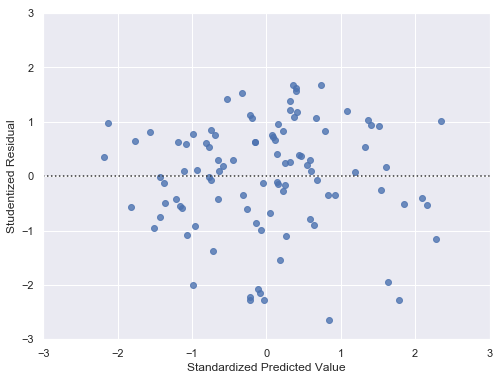

In [485]:
plot_standardized_residuals(dependent_var, varse)

### FIGURE 11 - Standardized Partial Regression Plots

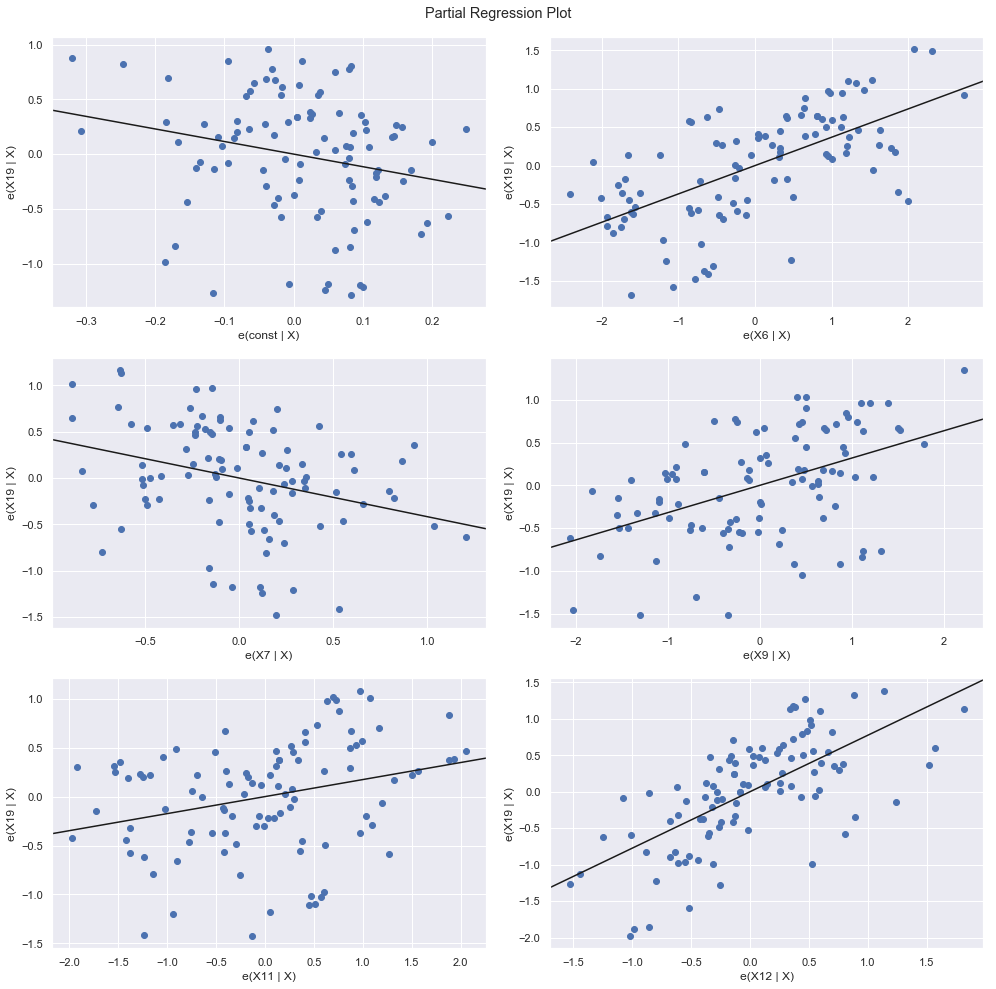

In [486]:
partial_regression_plots(dependent_var, ['X6', 'X7', 'X9', 'X11', 'X12'])

### FIGURE 12 - Normal Probability Plot: Standardized Residuals

<Figure size 432x288 with 0 Axes>

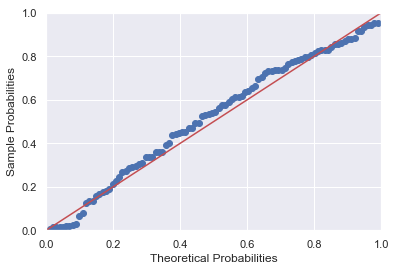

In [487]:
norm_prob_residuals_plot(dependent_var, varse)

**Normality** The final assumption we will check is normality of the error term of the variate with a visual examination of the normal probability plots of the residuals.
As shown in **Figure 12**, the values fall along the diagonal with no substantial or systematic departures; thus, the residuals are considered to represent a normal distribution. The regression variate is found to meet the assumption of normality.

**Applying Remedies for Assumption Violations** In an examination of individual variables, the only remedies needed are the transformations of **X6, X7, X12, X13, X16, and X17**. A set of differing transformations were used 
- The **squared term (X6 and X16)**
- **Logarithm (X7)**
- **Cubed term (X13**)
- **Inverse (X16**). 
- Only in the case of **X12** did the transformation not achieve normality.

If we substitute these variables for their original values and reestimate the regression equation with a stepwise procedure, we achieve almost identical results. The same variables enter the equation with no substantive differences in either the estimated coefficients or overall model fit as assessed with Rˆ2 and standard error of the estimate. The independent variables not in the equation still show nonsignificant levels for entry—even those that were transformed. Thus, in this case, the remedies for violating the assumptions improved the prediction slightly but did not alter the substantive findings.

**IDENTIFYING OUTLIERS AS INFLUENTIAL OBSERVATIONS** 
    
For our final analysis, we attempt to identify any observations that are influential (having a disproportionate impact on the regression results) and determine whether they should be excluded from the analysis. Although more detailed procedures are available for identifying outliers as influential observations, we address the use of residuals in identifying outliers in the following section.

The most basic diagnostic tool involves the residuals and identification of any outliers—that is, observations not predicted well by the regression equation that have large residuals. **Figure 13** shows the studentized residuals for each observation. Because the values correspond to *t values*, upper and lower limits can be set once the desired confidence interval has been established. Perhaps the most widely used level is the **95%** confidence interval (**α = .05**). The corresponding *t value* is **1.96**, thus identifying statistically significant residuals as those with residuals greater than this value (**1.96**). Seven observations can be seen in **Figure 13** (**2, 10, 20, 45, 52, 80, and 99**) to have significant residuals and thus be classified as outliers. Outliers are important because they are observations not represented by the regression equation for one or more reasons, any one of which may be an influential effect on the equation that requires a remedy.

Examination of the residuals also can be done through the partial regression plots (see **Figure 11**). These plots help to identify influential observations for each independent–dependent variable relationship. Consistently across each graph in **Figure 11**, the points at the lower portion are those observations identified as having high negative residuals (observations 2, 10, 20, 45, 52, 80, and 99 in Figure 13). These points are not well represented by the relationship and thus affect the partial correlation as well.

### FIGURE 13 Plot of Studentized Residuals

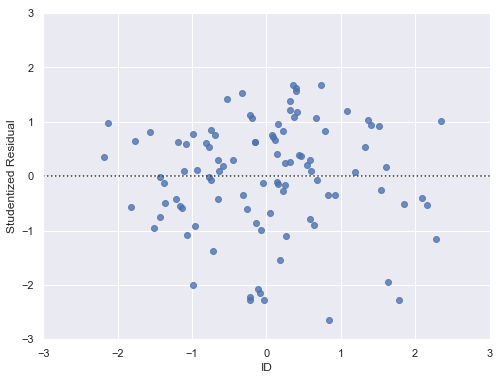

In [488]:
model = OLS(dependent_var,varse)

infl = model.get_influence()

x = preprocessing.scale(model.fittedvalues)
y = infl.resid_studentized_external

plt.figure(figsize=(8,6))
ax = sns.residplot(x, y)
ax.set_ylim(-3,3)
ax.set_xlim(-3,3)
ax.set(xlabel='ID', ylabel='Studentized Residual')
plt.show()

#FIXME y = (-2,2); x = (1,100)

### Stage 5: Interpreting the Regression Variate
With the model estimation completed, the regression variate specified, and the diagnostic tests that confirm the appropriateness of the results administered, we can now examine our predictive equation based on five independent variables (X6, X7, X9, X11, and X12).

**INTERPRETATION OF THE REGRESSION COEFFICIENTS** The first task is to evaluate the regression coefficients for the estimated signs, focusing on those of unexpected direction.

The section of **Table 11 headed “Variables Entered into the Regression Equation”** yields the prediction equation from the column labeled “Regression Coefficient: B.” From this column, we read the constant term (-1.151) and the coefficients (.319, .369, .775, -.417, and .174) for X9, X6, X12, X7, and X11, respectively. The predictive equation would be written

    Y = -1.151 + .319X9 + .369X6 + .775X12 + (-.417)X7 + .174X11

With this equation, the expected customer satisfaction level for any customer could be calculated if that customer’s evaluations of HBAT are known. For illustration, let us assume that a customer rated HBAT with a value of 6.0 for each of these five measures. The predicted customer satisfaction level for that customer would be

    Predicted Customer = -1.151 + .319 * 6 + .369 * 6 + .775 * 6 +(-.417) * 6 + .174 * 6
    Satisfaction = -1.151 + 1.914 + 2.214 + 4.650 - 2.502 + 1.044 = 6.169

All of the variables except one have positive coefficients. Of particular note is the reversed sign for **X7 (E-Commerce)**, suggesting that an increase in perceptions on this variable has a negative impact on predicted customer satisfaction. All the other variables have positive coefficients, meaning that more positive perceptions of HBAT (higher values) increase customer satisfaction.

Does **X7**, then, somehow operate differently from the other variables? In this instance, the bivariate correlation between X7 and X19 is positive, indicating that when considered separately, X7 has a positive relationship with X19, just as the other variables. We will discuss in the following section the impact of multicollinearity on the reversal of signs for estimated coefficients.

**ASSESSING VARIABLE IMPORTANCE** In addition to providing a basis for predicting customer satisfaction, the regression coefficients also provide a means of assessing the relative importance of the individual variables in the overall prediction of customer satisfaction. When all the variables are expressed in a standardized scale, then the regression coefficients represent relative importance. However, in other instances the **beta weight** is the preferred measure of relative importance.

In **Table 11**, the beta coefficients are listed in the column headed **“Regression Coefficients: Beta.”** For our example, **X12** was the most important, followed by **X6, X9, X7**, and finally **X11**. With a steady decline in size of the beta coefficients across the variables, it is difficult to categorize variables as high, low, or otherwise. However, viewing the relative magnitudes does indicate that, for example, **X12** shows a more marked effect (three times as much) than X11. Thus, to the extent that **X12** can be increased uniquely from other perceptions, it represents the most direct way, ceterus paribus, of increasing **X19**.

**MEASURING THE DEGREE AND IMPACT OF MULTICOLLINEARITY** As discussed earlier, highly collinear variables can distort the results substantially or make them quite unstable and thus not generalizable. Two measures are available for testing the impact of collinearity: 
- (1) calculating the **tolerance** and **VIF** values and 
- (2) using the condition indices and decomposing the regression coefficient variance. 

The tolerance value is *1 minus the proportion of the variable’s variance explained by the other independent variables*. Thus, a **high tolerance value** indicates **little collinearity**, and **tolerance values approaching zero indicate that the variable is almost totally accounted for by the other variables (high multicollinearity**). The **VIF** is the reciprocal of the tolerance value; thus we look for small VIF values as indicative of low correlation among variables.

**Diagnosing Multicollinearity** In our example, tolerance values for the variables in the equation range from **.728 (X6) to .347 (X12)**, indicating a wide range of multicollinearity effects (see **Table 11**). **Likewise, the VIF values range from 1.373 to 2.701**. Even though none of these values indicate levels of multicollinearity that should seriously distort the regression variate, we must be careful even with these levels to understand their effects, especially on the stepwise estimation process.

**Impacts Due to Multicollinearity** Although multicollinearity is not so high that the researcher must take corrective action before valid results can be obtained, multicollinearity still has impact on the estimation process, particularly on the composition of the variate and the estimated regression coefficients.

If you examine the bivariate correlations, after X9 (the first variable added to the regression variate in the stepwise process), the second-highest correlation with the dependent variable is **X18**, followed by **X11**, and **X16**. Yet due to collinearity with **X9**, the second variable entered was **X6**, only the sixth highest bivariate correlation with **X19**.

The impacts of multicollinearity are seen repeatedly throughout the estimation process, such that the final set of five variables entered into the regression model (**X6, X7, X9, X11, and X12**) represent the first, sixth, fifth, eighth, and third highest correlations with the dependent variable, respectively. 
Variables with the second highest correlation (**X18 at .577**) and fourth highest correlation (**X16 at .522**) are never entered into the regression model. Does their exclusion mean they are unimportant? Are they lacking in impact? If a researcher went only by the estimated regression model, multicollinearity would cause serious problems in interpretation. What happened is that X16 and X18 are highly correlated with X9, to such an extent that they have little unique explanatory power apart from that shared with X9. Yet by themselves, or if X9 was not allowed to enter the model, they would be important predictors of customer satisfaction. The extent of multicollinearity among these three variables is evidenced in that these three variables may be found to all form one of the four factors arising from the HBAT perceptions.

In addition to affecting the composition of the variate, multicollinearity has a distinct impact on the signs of the estimated coefficients. In this situation, it relates to the collinearity between **X12** and **X7**. As noted in our earlier discussion about multicollinearity, one possible effect is the reversal of sign for an estimated regression coefficient from the expected direction represented in the bivariate correlation. Here, the high positive correlation between X12 and X7 (correlation = .792) causes the sign for the regression coefficient for X7 to change from positive (in the bivariate correlation) to a negative sign. If the researcher did not investigate the extent of multicollinearity and its impact, the inappropriate conclusion might be drawn that increases in **X7** decrease **X19**.

Thus, the researcher must understand the basic relationships supported by the conceptual theory underlying the original model specification and make interpretation based on this theory, not just on the estimated variate.

The researcher must never allow an estimation procedure to dictate the interpretation of the results, but instead must understand the issues of interpretation accompanying each estimation procedure. For example, if all 13 independent variables are entered into the regression variate, the researcher must still contend with the effects of collinearity on the interpretation of the coefficients, but in a different manner than if stepwise were used.

### Stage 6: Validating the Results

The final task facing the researcher involves the validation process of the regression model. The primary concern of this process is to ensure that the results are generalizable to the population and not specific to the sample used in estimation. The most direct approach to validation is to obtain another sample from the population and assess the correspondence of the results from the two samples. In the absence of an additional sample, the researcher can assess the validity of the results in several approaches, including an assessment of the adjusted **Rˆ2** or estimating the regression model on two or more subsamples of the data.

- Examining the adjusted **Rˆ2** value reveals little loss in predictive power when compared to the Rˆ2 value (**.780 versus .791**, see **Table 11**), which indicates a lack of overfitting that would be shown by a more marked difference between the two values. Moreover, with five variables in the model, it maintains an adequate ratio of observations to variables in the variate.

- A second approach is to divide the sample into two subsamples, estimate the regression model for each subsample, and compare the results. **Table 13** contains the stepwise models estimated for two subsamples of 50 observations each. Comparison of the overall model fit demonstrates a high level of similarity of the results in terms of R2, adjusted R2, and the standard error of the estimate. Yet in comparing the individual coefficients, some differences do appear. 
    - In sample 1, **X9** did not enter in the stepwise results as it did in sample 2 and the overall sample. Instead, **X16**, highly collinear with X9, entered. Moreover, **X12** had a markedly greater beta weight in sample 1 than found in the overall results. 
    - In the second sample, four of the variables entered as with the overall results, but **X11**, the least forceful variable in the overall results, did not enter the model. The omission of **X11** in one of the subsamples confirms that it was a marginal predictor, as indicated by the low beta and t values in the overall model.

In [500]:
#TODO - TABLE 13 - Split-Sample Validation of Stepwise Estimation

**Evaluating Alternative Regression Models**
The stepwise regression model examined in the previous discussion provided a solid evaluation of the research problem as formulated. However, a researcher is always well served in evaluating alternative regression models in the search of additional explanatory power and confirmation of earlier results. In this section, we examine two additional regression models: 
- One model including all 13 independent variables in a confirmatory approach
- And a second model adding a nonmetric variable (X3, Firm Size) through the use of a dummy variable.

#### TABLE 14 Multiple Regression Results Using a Confirmatory Estimation Approach with All 13 Independent Variables

In [490]:
varse = ['X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18']
results = OLS(dependent_var, varse)
results.summary().tables[0]

Dep. Variable:,X19,R-squared:,0.804
Model:,OLS,Adj. R-squared:,0.774
Method:,Least Squares,F-statistic:,27.11
Date:,"Mon, 25 Mar 2019",Prob (F-statistic):,5.89e-25
Time:,13:57:25,Log-Likelihood:,-77.496
No. Observations:,100,AIC:,183.0
Df Residuals:,86,BIC:,219.5
Df Model:,13,,
Covariance Type:,nonrobust,,


In [491]:
stde_est = np.sqrt(results.ssr / results.df_resid)

#### Analysis of Variance

In [492]:
anova(dependent_var, varse)

,sum_sq,df,F,PR(>F)
X6,16.447,1.0,51.277,0.000
X7,3.580,1.0,11.162,0.001
X8,0.094,1.0,0.294,0.589
X9,0.711,1.0,2.218,0.140
X10,0.096,1.0,0.300,0.585
X11,0.592,1.0,1.846,0.178
X12,21.329,1.0,66.499,0.000
X13,0.311,1.0,0.970,0.328
X14,0.233,1.0,0.726,0.397
X15,0.002,1.0,0.006,0.941


#### Variables Entered Into the Regression Model

In [493]:
vars_entered_into_rm = variables_entered(dependent_var, varse) 
vars_entered_into_rm

,coef,std err,t,P>|t|,[0.025,0.975],Tolerance,VIF
X6,0.377,0.053,7.161,0.000,0.273,0.482,0.598,1.672
X7,-0.456,0.137,-3.341,0.001,-0.727,-0.185,0.354,2.823
X8,0.035,0.065,0.542,0.589,-0.094,0.164,0.328,3.047
X9,0.154,0.104,1.489,0.140,-0.052,0.360,0.207,4.838
X10,-0.034,0.063,-0.548,0.585,-0.159,0.090,0.646,1.547
X11,0.362,0.267,1.359,0.178,-0.168,0.893,0.026,37.978
X12,0.827,0.101,8.155,0.000,0.626,1.029,0.274,3.654
X13,-0.048,0.048,-0.985,0.328,-0.143,0.048,0.584,1.712
X14,-0.107,0.126,-0.852,0.397,-0.357,0.143,0.306,3.268
X15,-0.003,0.040,-0.074,0.941,-0.082,0.076,0.930,1.075


**CONFIRMATORY REGRESSION MODEL** A primary alternative to the stepwise regression estimation method is the confirmatory approach, whereby the researcher specifies the independent variable to be included in the regression equation. In this manner, the researcher retains complete control over the regression variate in terms of both prediction and explanation. This approach is especially appropriate in situations of replication of prior research efforts or for validation purposes.

In this situation, the confirmatory perspective involves the inclusion of all 13 perceptual measures as independent variables. These same variables are considered in the stepwise estimation process, but in this instance all are directly entered into the regression equation at one time. Here the researcher can judge the potential impacts of multicollinearity on the selection of independent variables and the effect on overall model fit from including all seven variables.

The primary comparison between the stepwise and confirmatory procedures involves examination of the overall model fit of each procedure as well as the interpretations drawn from each set of results.

- **Impact on Overall Model Fit** The results in **Table 14** are similar to the final results achieved through stepwise estimation (see **Table 11**), with two notable exceptions:
    1. Even though more independent variables are included, the overall model fit decreases. Whereas the coefficient of determination **increases** (**.889 to .897**) because of the additional independent variables, the adjusted **Rˆ2 decreases slightly** (**.780 to .774**), which indicates the inclusion of several independent variables that were nonsignificant in the regression equation. Although they contribute to the overall Rˆ2 value, they detract from the adjusted Rˆ2. This change illustrates the role of the adjusted Rˆ2 in comparing regression variates with differing numbers of independent variables.
    2. Another indication of the overall poorer fit of the confirmatory model is the increase in the **standard error of the estimate (SEE) from .559 to .566**, which illustrates that overall R2 should not be the sole criterion for predictive accuracy because it can be influenced by many factors, one being the number of independent variables.

- **Impact on Variate Interpretation** The other difference is in the regression variate, where multicollinearity affects the number and strength of the significant variables.
    1. First, only three variables (**X6, X7, and X12**) are statistically significant, whereas the stepwise model contains two more variables (**X9 and X11**). In the stepwise model, **X11** was the least significant variable, with a **significance level of .005**. When the confirmatory approach is used, the multicollinearity with other variables (as indicated by its **tolerance value of .026**) renders it nonsignificant. The same happens to **X9**, which was the first variable entered in the stepwise solution, but it now has a nonsignificant coefficient in the confirmatory model. Again, multicollinearity had a sizeable impact, reflected in its **tolerance value of .207**.
    2. The impact of multicollinearity on other variables not in the stepwise model is also substantial. In the confirmatory approach, three variables (**X11, X17, and X18**) have tolerance **values under .05** (with corresponding **VIF values of 33.3, 37.9, and 44.0**), meaning that **95 percent or more of their variance is accounted for by the other HBAT perceptions**. In such situations, it is practically impossible for these variables to be significant predictors. Six other variables have tolerance **values under .50**, indicating that the regression model variables account for more than half of the variance in these variables.
    
    Thus, the inclusion of all variables creates issues in estimation and interpretation.
    
    The confirmatory approach provides the researcher with control over the regression variate, but at the possible cost of a regression equation with poorer prediction and explanation if the researcher does not closely examine the results. The confirmatory and sequential approaches both have strengths and weaknesses that should be considered in their use, but the prudent researcher will employ both approaches in order to address the strengths of each.

    
**INCLUDING A NONMETRIC INDEPENDENT VARIABLE** The prior discussion focused on the confirmatory estimation method as an alternative for possibly increasing prediction and explanation, but the researcher also should consider the possible improvement from the addition of nonmetric independent variables.

In this example, the variable of **firm size** (**X3**), which has the two categories (large and small firms), will be included in the stepwise estimation process. The variable is already coded in the appropriate form, with large firms (500 or more employees) coded as **1** and small firms as **0**.

The variable can be directly included in the regression equation to represent the difference in customer satisfaction between large and small firms, given the other variables in the regression equation. Specifically, because large firms have the value 1, small firms act as the reference category.

The regression coefficient is interpreted as the value for large firms compared to small firms. A positive coefficient indicates that large firms have higher **customer satisfaction** than small firms, whereas a negative coefficient indicates that small firms have higher customer satisfaction. The amount of the coefficient represents the difference in customer satisfaction between the means of the two groups, controlling for all other variables in the model.

#### TABLE 15 Multiple Regression Results Adding X3 (Firm Size) as an Independent Variable by Using a Dummy Variable

In [494]:
corr_df['X3'] = df['X3']
cols.append('X3')

In [495]:
varse = ['X9', 'X6', 'X12', 'X7', 'X11', 'X3']
results = OLS(dependent_var, varse)
results.summary().tables[0]

Dep. Variable:,X19,R-squared:,0.801
Model:,OLS,Adj. R-squared:,0.788
Method:,Least Squares,F-statistic:,62.46
Date:,"Mon, 25 Mar 2019",Prob (F-statistic):,1.78e-30
Time:,13:57:26,Log-Likelihood:,-78.171
No. Observations:,100,AIC:,170.3
Df Residuals:,93,BIC:,188.6
Df Model:,6,,
Covariance Type:,nonrobust,,


In [496]:
stde_est = np.sqrt(results.ssr / results.df_resid)

#### Analysis of Variance

In [497]:
anova(dependent_var, varse)

,sum_sq,df,F,PR(>F)
X9,7.499,1.0,24.944,0.000
X6,18.672,1.0,62.111,0.000
X12,16.943,1.0,56.358,0.000
X7,1.838,1.0,6.114,0.015
X11,3.319,1.0,11.040,0.001
X3,1.464,1.0,4.870,0.030
Residual,27.958,93.0,NaN,NaN


#### Variables Entered Into the Regression Model

In [498]:
vars_entered_into_rm = variables_entered(dependent_var, varse) 
vars_entered_into_rm

,coef,std err,t,P>|t|,[0.025,0.975],Tolerance,VIF
X9,0.300,0.060,4.994,0.000,0.181,0.419,0.576,1.736
X6,0.365,0.046,7.881,0.000,0.273,0.457,0.727,1.375
X12,0.701,0.093,7.507,0.000,0.516,0.887,0.303,3.304
X7,-0.333,0.135,-2.473,0.015,-0.601,-0.066,0.341,2.935
X11,0.203,0.061,3.323,0.001,0.082,0.325,0.469,2.130
X3,0.271,0.123,2.207,0.030,0.027,0.515,0.798,1.253


**Table 15** contains the results of the addition of **X3** in a stepwise model, where it was added with the five variables that formed the stepwise model earlier in this section (see **Table 11**). Examination of the overall fit statistics indicates minimal improvement, with all of the measures (Rˆ2, adjusted Rˆ2, and SEE) increasing over the original stepwise model (see **Table 11**).

When we examine the regression coefficients, note that the **coefficient for X3 is .271** and is significant at the **.03** level. The positive value of the coefficient indicates that large firms, given their characteristics on the other five independent variables in the equation, still have a customer satisfaction level that is about a quarter point higher (**.271**) on the 10-point customer satisfaction question. The use of **X3** increased the prediction only slightly. From an explanatory perspective, though, we now know that large firms enjoy higher customer satisfaction.

This example illustrates the manner in which the researcher can add nonmetric variables to the metric variables in the regression variate and improve both prediction and explanation.

**A Managerial Overview of the Results** The regression results, including the complementary evaluation of the confirmatory model and the addition of the nonmetric variable, all assist in addressing the basic research question: What affects customer satisfaction? In formulating a response, the researcher must consider two aspects: prediction and explanation.

- In terms of prediction, the regression models all achieve high levels of predictive accuracy. The amount of variance explained equals about **80%** and the expected error rate for any prediction at the **95%** confidence level is about **1.1** points. In this type of research setting, these levels, augmented by the results supporting model validity, provide the highest levels of assurance as to the quality and accuracy of the regression models as the basis for developing business strategies.

- In terms of explanation, all of the estimated models arrived at essentially the same results: 
    - three strong influences (**X12**, Salesforce Image; **X6**, Product Quality; and **X9**, Complaint Resolution). Increases in any of these variables result in increases in customer satisfaction. For example, an increase of 1 point in the customer’s perception of Salesforce Image (**X12**) will result in an average increase of at least seven-tenths (**.701**) of a point on the 10-point customer satisfaction scale. Similar results are seen for the other variables. 
    - Moreover, at least one firm characteristic, **firm size**, demonstrated a significant effect on customer satisfaction. Larger firms have levels of satisfaction about a quarter of a point (**.271**) higher than the smaller firms. 

These results provide management with a framework for developing strategies for improving customer satisfaction. Actions directed toward increasing the perceptions of HBAT can be justified in light of the corresponding increases in customer satisfaction.

The impact of two other variables (**X7**, E-Commerce; **X11**, Product Line) on customer satisfaction is less certain. Even though these two variables were included in the stepwise solution, their combined explained variance was only **.038** out of an overall model **Rˆ2 **of **.791**. Both variables were not significant in the confirmatory model. Moreover, **X7** had the reversed sign in the stepwise model, which, although due to multicollinearity, still represents a result contrary to managerial strategy development. As a result, the researcher should consider reducing the influence allotted to these variables and even possibly omit them from consideration as influences on customer satisfaction.

In developing any conclusions or business plans from these results, the researcher should also note that the three major influences (**X12, X6, and X9**) are primary components of the perceptual dimensions, which can be identified through factor analysis. These dimensions, which represent broad measures of customers’ perceptions of HBAT, should thus also be considered in any conclusions. To state that only these three specific variables are influences on customer satisfaction would be a serious misstatement of the more complex patterns of collinearity among variables. Thus, these variables are better viewed as representatives of the perceptual dimensions, with the other variables in each dimension also considered in any conclusions drawn from these results.

Management now has an objective analysis that confirms not only the specific influences of key variables, but also the perceptual dimensions that must be considered in any form of business planning regarding strategies aimed at affecting customer satisfaction.